In [11]:
def most_similarity_matrix(time_series, T=20, tp=50):
    G = visibility_graph(time_series)
    adj_matrix = np.array(adjacency_matrix(G).todense())
    E = G.number_of_edges()
    k = adj_matrix.sum(1)
    P = adj_matrix/k
    n = k.shape[0]
    s_srw = np.zeros((n,n))
    pi = np.diag(np.ones(n))
    for t in range(T):
        pi = P@pi
        s_srw += (k*pi+k.T*pi.T)/(2*E)
    if tp != 0:
        triup = np.triu(s_srw,k=-tp)
        triup[triup != 0] = 1
        s_srw = np.tril(s_srw,k=-1) * triup
    return s_srw

def ts_forcast_3Regimed_weighted_compact(df , time_serie):
    s_srw = most_similarity_matrix(time_serie, T=20,tp=50)
    sum_s = s_srw.sum(axis=1)
    sum_s[sum_s == 0] = np.inf
    ws_m = (s_srw.T/sum_s).T
    ws = np.zeros((ws_m.shape[0], tp))

    srw = s_srw
    indx = []
    rg_3 = []
    ms_reg = []
    total_y_indexs = []
    total_y_srws = []
    tp = 50
    for k in range(len(srw)):
        total_y_indexs.append([])
        total_y_srws.append([])
        indx.append([])
        # indx[-1].append(0)
        rg_3.append([])
        rg_3[-1].append(df.iloc[k]['3pn'])
        for i in range(tp):
            indx[-1].append(np.where(srw[k] == np.sort(srw[k])[::-1][:tp][i])[0][0])
            rg_3[-1].append(df.iloc[indx[-1][-1]]['3pn'])

        if rg_3[k][0] != 2:
            same_reg = np.where(rg_3[k]==rg_3[k][0])[0]
            turn_points = np.where(np.array(rg_3[k])==2)[0]
            num_same_regime = len(same_reg)
            num_turn_ponits = len(turn_points)
            indx_same = np.array(indx[k])[list(same_reg[1:]-1)]
            indx_2 = np.array(indx[k])[list(turn_points-1)]
            total_y_indexs[-1].append(np.concatenate((indx_same,indx_2), axis=0))
            srw[k][indx_2] *= num_turn_ponits
            srw[k][indx_same] *= num_same_regime
            ssr = srw[k][total_y_indexs[-1]]


            total_y_srws[-1].append(ssr[0]/sum(ssr[0]))

        if rg_3[k][0] == 2:
            same_reg = np.where(rg_3[k]==rg_3[k][0])[0]
            other_points = np.where(np.array(rg_3[k])!=2)[0]
            num_same_regime = len(same_reg)
            num_turn_ponits = len(other_points)
            indx_same = np.array(indx[k])[list(same_reg[1:]-1)]
            indx_2 = np.array(indx[k])[list(other_points-1)]
            total_y_indexs[-1].append(np.concatenate((indx_same,indx_2), axis=0))

            srw[k][indx_2] *= num_turn_ponits
            srw[k][indx_same] *= num_same_regime 

            ssr = srw[k][total_y_indexs[-1]]
            # ssr_0 , ssr_1 = np.unique(ssr[0], return_index=True)
            # ssr = ssr_0[np.argsort(ssr_1)]
            # ssr = ssr[ssr!=0]
            # total_y_indexs = total_y_indexs[np.argsort(ssr_1)]

            total_y_srws[-1].append(ssr[0]/sum(ssr[0]))


    start_point = 31
    forcast_ts = np.zeros_like(time_serie)
    forcast_ts[:start_point] = time_serie[:start_point]
    for i in range(start_point-1,time_serie.shape[0]-1):
        y = time_serie[i]+(time_serie[i]-time_serie[total_y_indexs[i][0]])/(i-total_y_indexs[i][0])
        forcast_ts[i+1]=(total_y_srws[i]*y).sum()

    return forcast_ts

In [229]:
def error_bars( selected_data, forcast_ts):
    RMSE = math.sqrt(np.square(np.subtract(selected_data,forcast_ts)).mean())
    NRMSE = RMSE/(max(selected_data)-min(selected_data))
    MAPE=np.mean(np.abs((selected_data - forcast_ts)/selected_data))*100
    MAP=np.mean(np.abs((selected_data - forcast_ts)))
    return {'RMSE':RMSE, 'NRMSE':NRMSE, 'MAPE':MAPE, 'MAP':MAP}

In [230]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visibility_graph import visibility_graph
from networkx.linalg.graphmatrix import adjacency_matrix
import math
from ned import VG_Modules_Model2 as vg

In [231]:
tehran_index = pd.read_excel('../Data/Tehran_Indexes_Price_NoRegime.xlsx').set_index('date')

In [232]:
tehran_df = pd.read_excel('../Data/Tehran_Indexes_NormedReturned_Regimed.xlsx').set_index('date')

In [233]:
tehran_data_to_predict = tehran_index['index'].values

In [16]:
tehran_index['3pn'] = np.append(1, tehran_df['3_PN'].values)

In [234]:
time_serie = tehran_data_to_predict[-300:]

In [235]:
tp=300
s_srw = most_similarity_matrix(time_serie, T=20,tp=300)
sum_s = s_srw.sum(axis=1)
sum_s[sum_s == 0] = np.inf
ws_m = (s_srw.T/sum_s).T
ws = np.zeros((ws_m.shape[0], tp))

/var/folders/mj/xw3m0dws3yq8j2md9n8j3g940000gn/T/ipykernel_1143/421981716.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = np.array(adjacency_matrix(G).todense())


In [238]:
df = tehran_index[-300:]
srw = s_srw.copy()
indx = []
rg_3 = []
tp = 200

for k in range(len(srw)):
    indx.append([])
    indx[-1].append(k)
    rg_3.append([])
    rg_3[-1].append(df.iloc[k]['pn4'])
    for i in range(tp):
        indx[-1].append(np.where(srw[k] == np.sort(srw[k])[::-1][:tp][i])[0][0])
        rg_3[-1].append(df.iloc[indx[-1][-1]]['pn4'])


rg_3_new = []
for i in range(len(rg_3)):
    rg_3_new.append(rg_3[i][:i+1])
    
indx_new = []
for i in range(len(indx)):
    indx_new.append(indx[i][:i+1])

index_new_above_thr = []
reg_3_new_above_thr = []
for i in range(1,len(indx_new)):
    index_new_above_thr.append(np.array(indx_new[i])[ws_m[i][indx_new[i]] >= 0.01])
    reg_3_new_above_thr.append(np.array(rg_3_new[i])[ws_m[i][indx_new[i]] >= 0.01])

In [288]:
chosen_weightes_above_thr = [0,]
for k in range(1, time_serie.shape[0]):
    
    chosen_reg = rg_3_new[k][0]

    if df['today'].iloc[k] == '+':
        chosen_weights = srw[k][index_new_above_thr[k-1]]/sum(srw[k][index_new_above_thr[k-1]])
        chosen_regimes = reg_3_new_above_thr[k-1]
        chosen_weights[chosen_regimes == 1] *= 1
        chosen_weights[chosen_regimes == 2] *= 1
        chosen_weights[chosen_regimes == 3] *= 2
        chosen_weights[chosen_regimes == 4] *= 0
        
    elif df['today'].iloc[k] == '-':
        chosen_weights = srw[k][index_new_above_thr[k-1]]/sum(srw[k][index_new_above_thr[k-1]])
        chosen_regimes = reg_3_new_above_thr[k-1]
        chosen_weights[chosen_regimes == 1] *= 0
        chosen_weights[chosen_regimes == 2] *= 2
        chosen_weights[chosen_regimes == 3] *= 1
        chosen_weights[chosen_regimes == 4] *= 1
      
    chosen_weightes_above_thr.append(chosen_weights/sum(chosen_weights))

In [289]:
start_point = 31
forcast_ts = np.zeros_like(time_serie)
forcast_ts[:start_point] = time_serie[:start_point]
for i in range(start_point-1,time_serie.shape[0]-1):
    y = time_serie[i]+(time_serie[i]-time_serie[index_new_above_thr[i-1]])/(i-index_new_above_thr[i-1])
    forcast_ts[i+1]=(chosen_weightes_above_thr[i]*y).sum()
err = error_bars(time_serie, forcast_ts)
err

{'RMSE': 25226.937214127425,
 'NRMSE': 0.014547904988125223,
 'MAPE': 1.494845317896985,
 'MAP': 18684.078517501242}

In [257]:
vg2 = vg()
model_2_forcast_ts = vg2.ts_forcast_model2_weighted(time_serie, tp=30)
err2 = error_bars(time_serie, model_2_forcast_ts)
err2

/Users/hossein4527/MEGA/MEGAsync/Commit/Neda_PhD/neda_sep2023/Time_Series_Trend_Forcasting/Codes/ned.py:184: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = np.array(adjacency_matrix(G).todense())


{'RMSE': 25535.20304052492,
 'NRMSE': 0.014725676150571578,
 'MAPE': 1.50008733754958,
 'MAP': 18918.78273909618}

In [326]:
str(((err2['RMSE'] - err['RMSE'])/err2['RMSE'])*100)+' %'+' Better Performace at RMSE'

'1.2072190141126775 % Better Performace'

In [332]:
str(((err2['NRMSE'] - err['NRMSE'])/err2['NRMSE'])*100)+' %'+' Better Performace at NRMSE'

'1.2072190141126726 % Better Performace at NRMSE'

In [330]:
str(((err2['MAPE'] - err['MAPE'])/err2['MAPE'])*100)+' %'+' Better Performace at MAPE'

'0.3494476302398506 % Better Performace at MAPE'

In [333]:
str(((err2['MAP'] - err['MAP'])/err2['MAP'])*100)+' %'+' Better Performace at MAP'

'1.24058838685173 % Better Performace at MAP'

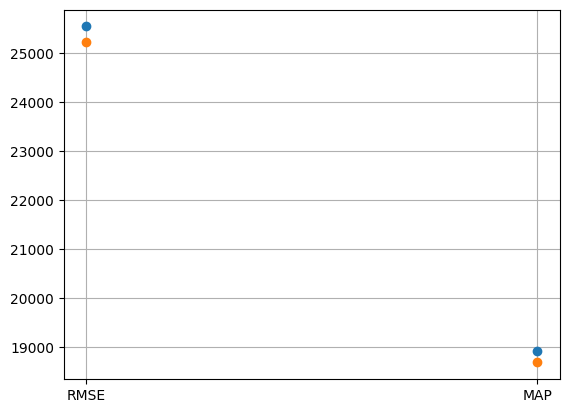

In [318]:
plt.plot([list(err2.values())[0], list(err2.values())[3]], 'o')
plt.plot([list(err.values())[0], list(err.values())[3]], 'o')

plt.xticks([0,1], [list(err.keys())[0], list(err.keys())[3]])
plt.grid()

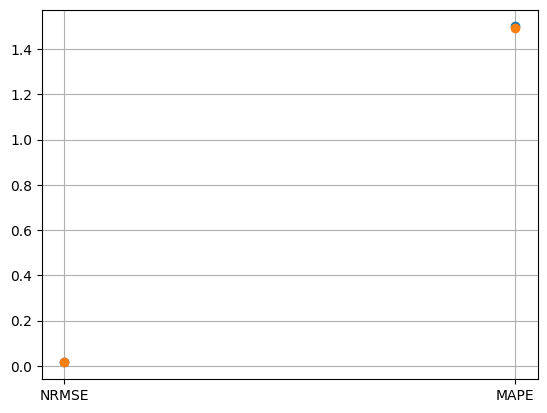

In [321]:
plt.plot([list(err2.values())[1], list(err2.values())[2]], 'o')
plt.plot([list(err.values())[1], list(err.values())[2]], 'o')

plt.xticks([0,1], [list(err.keys())[1], list(err.keys())[2]])
plt.grid()

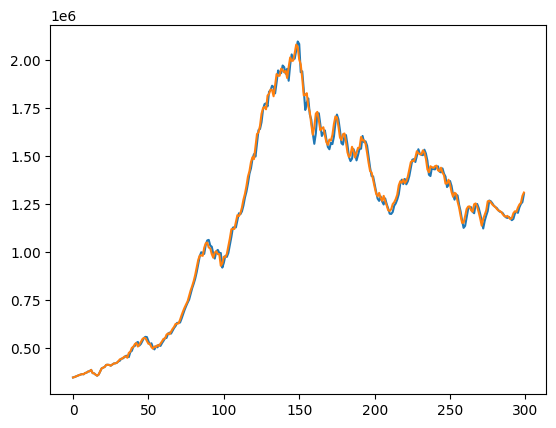

In [244]:
plt.plot(forcast_ts)
plt.plot(time_serie)

In [ ]:
plt.plot()

In [223]:
a = 50

In [224]:
time_serie[a]+(time_serie[a]-time_serie[index_new_above_thr[a-1]])/(a-index_new_above_thr[a-1])

array([523419.65344737, 509522.63033333, 505178.4475    , 519995.60944444,
       505316.243     , 523376.08068085, 523428.88193182, 523771.80503571,
       523393.55354348, 523354.53558   , 523413.60297778, 523471.5035    ,
       523454.837225  , 519346.873875  , 523377.47857143, 521751.22372727,
       523379.1066875 , 513749.73525   , 523890.04488889, 524126.00480556,
       523969.31086486, 524079.64934615, 524318.90852174, 524108.76736842,
       523970.21058065, 524400.90216   , 524035.1620625 , 524373.84270833,
       523508.75165854, 524462.57122727, 523978.50663333, 524272.23616667,
       524197.52482353, 524447.45268571, 523539.4064186 , 524570.15419048,
       523470.21030769, 523509.77333333])

In [225]:
time_serie[a]

519847.329

In [226]:
time_serie[a+1]

520211.767

In [227]:
forcast_ts[a+1]

518920.80224082223

In [228]:
model_2_forcast_ts[a+1]

518847.18590249727

In [216]:
index_new_above_thr[30-1][-8]

29

In [217]:
df.iloc[29]

index                        420668.0
Brent Oil                       58.41
Coin                       50120000.0
Euro                         149000.0
USD                          134070.0
CPI                        195.979186
HOUSE                   141426.598717
M1                      3232758.05417
M2                     23567569.35139
GDP                    5848086.426923
Gold                           1576.8
Agriculture                  112906.0
CoalMining                    12979.9
EstekrajeNaft                  2385.1
MahsolateFelezi              131644.0
SayerMadan                   126805.0
Mansojat                       6488.6
Wood                         526248.0
paper                        113262.0
EntesharVaChap              1473900.0
FaravardehayeNafti          1482230.0
Lastic                       109531.0
FelezateAsasi                266552.0
MashinAlat                   139417.0
DastgahayeBargi             2851410.0
VasayelErtebati               15384.6
AbzaralatePe

In [238]:
rg_3_new = []
for i in range(len(rg_3)):
    rg_3_new.append(rg_3[i][:i+1])

In [33]:
num_of_3s = []
num_of_2s = []
num_of_1s = []
for i in range(300):
    num_of_1s.append(len(np.where(np.array(rg_3_new[i])==1)[0]))
    num_of_2s.append(len(np.where(np.array(rg_3_new[i])==2)[0]))
    num_of_3s.append(len(np.where(np.array(rg_3_new[i])==3)[0]))


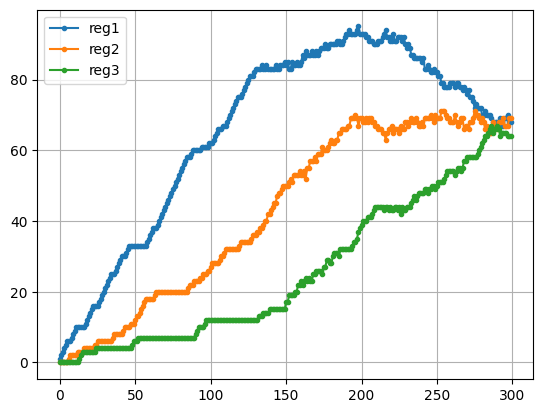

In [34]:
plt.plot(num_of_1s, '.-', label='reg1')
plt.plot(num_of_2s, '.-', label='reg2')
plt.plot(num_of_3s, '.-', label='reg3')
plt.legend()
plt.grid()

In [ ]:
    
same_reg_with_reg_1 = []
num_same_reg_with_reg_1 = []
indx_same_reg_with_reg_1 = []

same_reg_with_reg_2 = []
num_same_reg_with_reg_2 = []
indx_same_reg_with_reg_2 = []

same_reg_with_reg_3 = []
num_same_reg_with_reg_3 = []
indx_same_reg_with_reg_3 = []

for k in range(len(srw)):
    if rg_3_new[k][0] == 1:
        same_reg_with_reg_1.append(np.where(rg_3_new[k]==rg_3_new[k][0])[0])
        num_same_reg_with_reg_1.append(len(same_reg_with_reg_1[-1]))
        indx_same_reg_with_reg_1.append(np.array(indx_new[k])[list(same_reg_with_reg_1[-1])])
        
    elif rg_3_new[k][0] == 2:
        same_reg_with_reg_2.append(np.where(rg_3_new[k]==rg_3_new[k][0])[0])
        num_same_reg_with_reg_2.append(len(same_reg_with_reg_2[-1]))
        indx_same_reg_with_reg_2.append(np.array(indx_new[k])[list(same_reg_with_reg_2[-1])])  
        
    elif rg_3_new[k][0] == 3:
        same_reg_with_reg_3.append(np.where(rg_3_new[k]==rg_3_new[k][0])[0])
        num_same_reg_with_reg_3.append(len(same_reg_with_reg_3[-1]))
        indx_same_reg_with_reg_3.append(np.array(indx_new[k])[list(same_reg_with_reg_3[-1])]) 
        
#         num_turn_ponits = len(turn_points)
#         turn_points = np.where(np.array(rg_3[k])==2)[0]
#         indx_2 = np.array(indx[k])[list(turn_points-1)]
#         total_y_indexs[-1].append(np.concatenate((indx_same,indx_2), axis=0))
#         srw[k][indx_2] *= num_turn_ponits
#         srw[k][indx_same] *= num_same_regime
#         ssr = srw[k][total_y_indexs[-1]]


#         total_y_srws[-1].append(ssr[0]/sum(ssr[0]))